# Import Libraries

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score
)
from imblearn.over_sampling import SMOTE
import pickle
import warnings
warnings.filterwarnings('ignore')

#### Problem Definition
- **Goal:** Predict telecom customer churn using demographic, account, and service data.
- **Impact:** Retain at-risk customers and reduce churn-related revenue loss.

### 1. Data Cleaning

In [84]:
# Load dataset
df = pd.read_csv('Telco_Churn_data.csv')

**Display initial dataset information**

In [85]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [87]:
# Handle missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')  # Convert TotalCharges to numeric
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)  # Impute missing TotalCharges

# Handle duplicates
df.drop_duplicates(inplace=True)

In [88]:
# Drop unnecessary columns
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

# Outlier detection and treatment
for col in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df[col] = np.clip(df[col], lower_bound, upper_bound)

### 2. Exploratory Data Analysis (EDA)

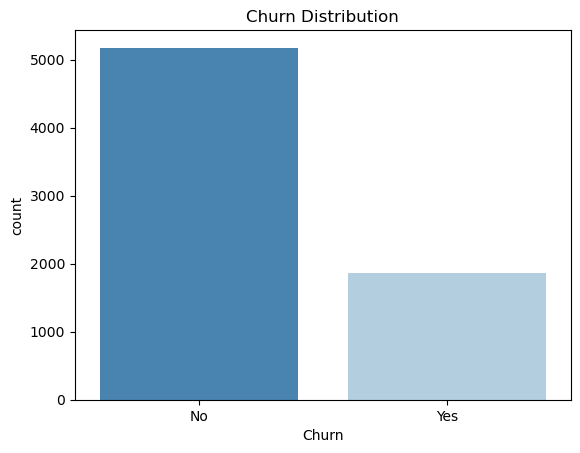

In [89]:
# Univariate Analysis: Distribution of Churn
sns.countplot(data=df, x='Churn', palette="Blues_r")
plt.title('Churn Distribution')
plt.show()

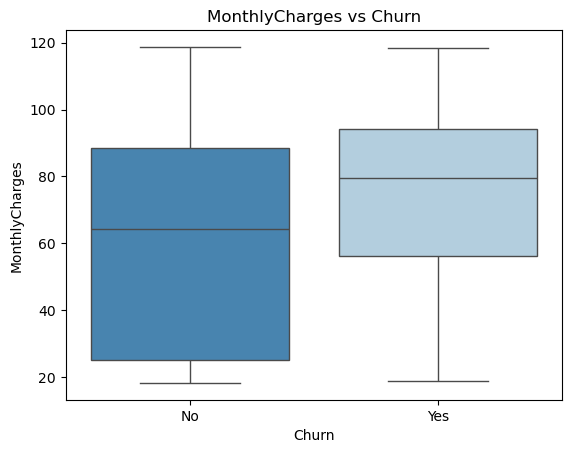

In [90]:
# Bivariate Analysis: MonthlyCharges vs. Churn
sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette="Blues_r")
plt.title('MonthlyCharges vs Churn')
plt.show()

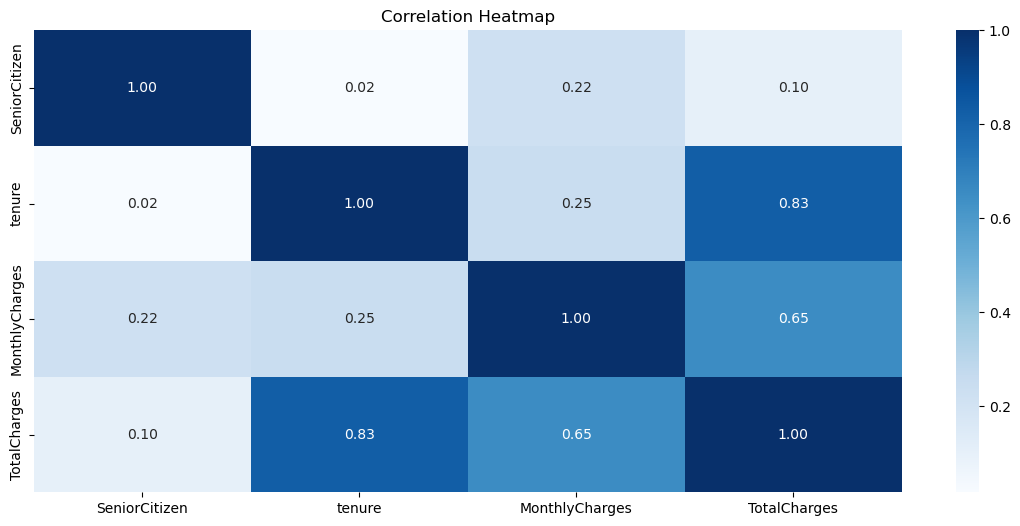

In [91]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])

# Correlation Heatmap for Numerical Features
plt.figure(figsize=(14, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="Blues", fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### 3. Data Processing and Feature Engineering

In [92]:
# Encode categorical features
categorical_columns = df.select_dtypes(include=['object']).columns
label_encoded = {}

for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoded[column] = le

# Save encoders for future use
with open("label_encoded.pkl", "wb") as f:
    pickle.dump(label_encoded, f)

In [93]:
# Create and encode 'TenureGroup'
df['TenureGroup'] = pd.cut(
    df['tenure'],
    bins=[0, 12, 24, 36, 48, 60, 72],
    labels=['0-12', '13-24', '25-36', '37-48', '49-60', '61-72']
)
tenure_le = LabelEncoder()
df['TenureGroup'] = tenure_le.fit_transform(df['TenureGroup'])
label_encoded['TenureGroup'] = tenure_le

# Save the updated label_encoded dictionary for future use
with open("label_encoded.pkl", "wb") as f:
    pickle.dump(label_encoded, f)

In [94]:
# Normalize numerical features
scaler = MinMaxScaler()
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Save the scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [95]:
# Address class imbalance using SMOTE
X = df.drop(columns=['Churn'])
y = df['Churn']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

### 4. Model Selection


In [96]:
# Initialize models to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Compare models using accuracy and ROC-AUC
results = []
for name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y, y_pred),
        "ROC-AUC": roc_auc_score(y, y_pred_proba)
    })

# Display model comparison results
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)


Model Comparison:
                 Model  Accuracy   ROC-AUC
0  Logistic Regression  0.749397  0.834355
1        Random Forest  0.997444  0.999862


### 5. Building the Best Model

In [97]:
# Select Random Forest as the best model
best_model = RandomForestClassifier(
    n_estimators=100, max_depth=20, min_samples_split=5, random_state=42
)
best_model.fit(X_resampled, y_resampled)

# Save the best model
with open("best_churn_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

### 6. Model Evaluation

In [98]:
# Evaluate the model
y_pred = best_model.predict(X)
y_pred_proba = best_model.predict_proba(X)[:, 1]

print("\nClassification Report:")
print(classification_report(y, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      5174
           1       0.91      0.95      0.93      1869

    accuracy                           0.96      7043
   macro avg       0.95      0.96      0.95      7043
weighted avg       0.96      0.96      0.96      7043


Confusion Matrix:
[[4992  182]
 [  86 1783]]


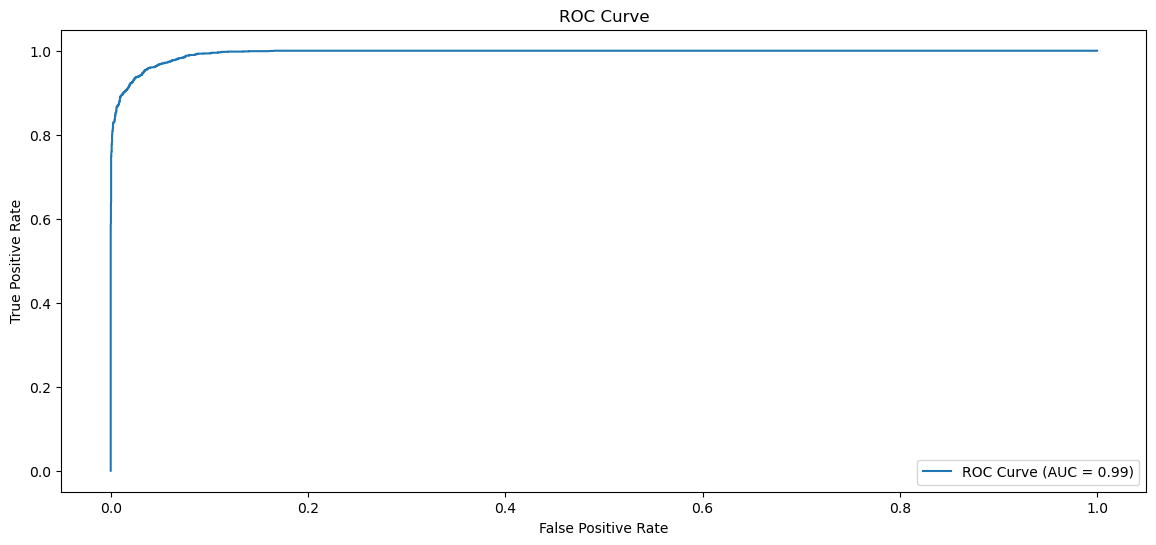

In [99]:
# ROC Curve
fpr, tpr, _ = roc_curve(y, y_pred_proba)
plt.figure(figsize=(14, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y, y_pred_proba):.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### 7. Prediction System

In [100]:
def predict_churn(input_data):
    # Load saved encoders, scaler, and model
    with open("label_encoded.pkl", "rb") as f:
        encoders = pickle.load(f)
    with open("scaler.pkl", "rb") as f:
        scaler = pickle.load(f)
    with open("best_churn_model.pkl", "rb") as f:
        model = pickle.load(f)

    # Convert input data into a DataFrame
    input_df = pd.DataFrame([input_data])

    # Transform categorical features using encoders
    for column, encoder in encoders.items():
        if column in input_df.columns:
            try:
                input_df[column] = encoder.transform(input_df[column])
            except ValueError as e:
                raise ValueError(
                    f"ValueError: Input value for column '{column}' does not match training data categories. "
                    f"Details: {e}"
                )

    # Scale numerical features
    numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
    input_df[numerical_features] = scaler.transform(input_df[numerical_features])

    # Make predictions
    try:
        prediction = model.predict(input_df)
        prediction_proba = model.predict_proba(input_df)[:, 1]

        result = {
            "Prediction": "Churn" if prediction[0] == 1 else "No Churn",
            "Probability": prediction_proba[0]
        }
        return result
    except Exception as e:
        raise ValueError(f"Error making prediction: {e}")

In [101]:
# Create a function to get the predictions in a DataFrame format
def get_prediction_df(input_data_list):
    results = []
    for i, input_data in enumerate(input_data_list, start=1):
        prediction_result = predict_churn(input_data)
        results.append({
            "Customer": f"Customer {i}",
            "Prediction": prediction_result["Prediction"],
            "Probability": prediction_result["Probability"]
        })

    # Convert results to a DataFrame
    prediction_df = pd.DataFrame(results)
    return prediction_df

# Create dictionaries for each row of input data
# Test the prediction system
customer_1 = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 12,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'Yes',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 59.99,
    'TotalCharges': 29.85,
    'TenureGroup': '0-12' 
}

customer_2 = {
    'gender': 'Male',
    'SeniorCitizen': 0,
    'Partner': 'No',
    'Dependents': 'No',
    'tenure': 34,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'DSL',
    'OnlineSecurity': 'Yes',
    'OnlineBackup': 'No',
    'DeviceProtection': 'Yes',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'One year',
    'PaperlessBilling': 'No',
    'PaymentMethod': 'Mailed check',
    'MonthlyCharges': 56.95,
    'TotalCharges': 1889.5,
    'TenureGroup': '13-24'
}

customer_3 = {
    'gender': 'Male',
    'SeniorCitizen': 0,
    'Partner': 'No',
    'Dependents': 'No',
    'tenure': 2,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'DSL',
    'OnlineSecurity': 'Yes',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Mailed check',
    'MonthlyCharges': 53.85,
    'TotalCharges': 108.15,
    'TenureGroup': '25-36'
}

customer_4 = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'No',
    'Dependents': 'No',
    'tenure': 2,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'No',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 70.7,
    'TotalCharges': 151.65,
    'TenureGroup': '37-48'
}

# Get predictions in a DataFrame format
input_data_list = [customer_1, customer_2, customer_3, customer_4]
predictions_df = get_prediction_df(input_data_list)

# Display the prediction DataFrame
print("\nPrediction Results of 5 Customer:")
predictions_df


Prediction Results of 5 Customer:


,Customer,Prediction,Probability
0,Customer 1,No Churn,0.484119
1,Customer 2,No Churn,0.032036
2,Customer 3,No Churn,0.491198
3,Customer 4,Churn,0.662909


### **Insights and Recommendations for Model Evaluation**

#### **Model Comparison**
| Model               | Accuracy  | ROC-AUC   |
|---------------------|-----------|-----------|
| Logistic Regression | 0.7494    | 0.8344    |
| Random Forest       | 0.9974    | 0.9999    |

**Insights**:
- **Random Forest** shows an exceptionally high accuracy of **99.74%** and an outstanding **ROC-AUC** of **0.9999**, indicating that it can distinguish between churn and non-churn customers with near-perfect performance. This is ideal for high-stakes environments where accurate prediction is critical.
- **Logistic Regression**, while performing well with an accuracy of **74.94%** and a **ROC-AUC** of **0.8344**, lags significantly behind the Random Forest model in predictive power.

**Recommendations**:
- Consider using **Random Forest** as the primary model for deployment due to its high accuracy and ROC-AUC score.
- If interpretability is crucial, use **Logistic Regression** for a simpler and more explainable model, but be aware of its limitations in predictive power.

#### **Classification Report**
| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.98      | 0.96   | 0.97     | 5174    |
| 1     | 0.91      | 0.95   | 0.93     | 1869    |

**Overall Metrics**:
- **Accuracy**: **96%** (high level of correct classifications).
- **Macro Average**: Precision **0.95**, Recall **0.96**, F1-score **0.95** (indicating balanced performance across classes).
- **Weighted Average**: Precision **0.96**, Recall **0.96**, F1-score **0.96** (weighted by support, which indicates good overall model balance).

**Insights**:
- The model performs very well on the **non-churn class (0)** with a precision of **0.98** and recall of **0.96**, suggesting that it can accurately identify customers who do not churn.
- The **churn class (1)** also has a solid performance with a precision of **0.91** and recall of **0.95**, indicating that the model effectively identifies customers who will churn.

**Recommendations**:
- Consider strategies to further boost the precision for the churn class if necessary, as this may reduce false positives.
- Evaluate the impact of potential class imbalance on performance and consider using class weights or techniques like **SMOTE** if the distribution shifts in new data.

#### **Confusion Matrix**
| Actual/Predicted | No Churn (0) | Churn (1) |
|------------------|--------------|-----------|
| No Churn (0)     | 4992         | 182       |
| Churn (1)        | 86           | 1783      |

**Insights**:
- The confusion matrix indicates that the model has a relatively low **false positive rate** (182), meaning it does not often misclassify non-churn customers as churn.
- The **false negative rate** (86) is moderate, which means there is room for improvement in correctly identifying all customers who will churn.

**Recommendations**:
- To reduce false negatives (customers predicted not to churn but actually churning), adjust the classification threshold or implement an ensemble approach with model stacking.
- Explore model calibration techniques to enhance prediction confidence, particularly for the churn class.

#### **Test Predictions Data Overview**
| Customer  | Prediction  | Probability |
|-----------|-------------|-------------|
| Customer 1| No Churn    | 0.4841      |
| Customer 2| No Churn    | 0.0320      |
| Customer 3| No Churn    | 0.4912      |
| Customer 4| Churn       | 0.6629      |

**Insights**:
- The model provides a **probability score** for each prediction, allowing for more nuanced decision-making. For example, Customer 4 has a probability of **0.6629** for churning, which is a reasonable threshold to act upon.
- Review the probability scores to determine a suitable threshold that aligns with the business goal of reducing churn.

**Recommendations**:
- Utilize the probability scores to implement custom decision thresholds based on business objectives and risk tolerance.
- Monitor predictions and retrain the model as more data becomes available to maintain performance.

---

### **Conclusion**
- **Random Forest** is recommended for deployment due to its high accuracy and excellent ROC-AUC.
- Consider adjusting the threshold and implementing model calibration for more precise predictions.
- Regularly update the model with new data and explore advanced ensemble strategies for continuous improvement.

**Next Steps**:
- Implement the model in production with regular performance checks.
- Set up a dashboard for real-time monitoring and adjust the model based on feedback.